# Import Libraries

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [3]:
train_data = datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./mnist", train=False, download=True, transform=transform)

In [4]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Visualization

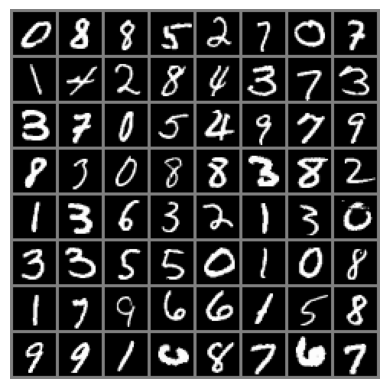

In [5]:
data_iter = iter(train_dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap="gray")
    plt.axis("off")
    plt.show()

imshow(make_grid(images, nrow=8))

# Network in Network (NiN)

In [6]:
class NIN(nn.Module):
    def __init__(self):
        super(NIN, self).__init__()
        self.blocks = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, kernel_size=1),
            nn.BatchNorm2d(160), nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, kernel_size=1),
            nn.BatchNorm2d(96), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.Dropout(inplace=True),

            # Block 2
            nn.Conv2d(96, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2, ceil_mode=True),
            nn.Dropout(inplace=True),

            # Block 3
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.Conv2d(192, 10, kernel_size=1),
            nn.BatchNorm2d(10), nn.ReLU(inplace=True),
            nn.AvgPool2d(7, stride=2, ceil_mode=True)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = x.view(x.size(0), 10)
        return torch.squeeze(x)

In [7]:
model = NIN()
model.to(device)

NIN(
  (blocks): Sequential(
    (0): Conv2d(1, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Dropout(p=0.5, inplace=True)
    (11): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
    (15): BatchNorm2d(192, eps=1e-05, mom

# Train

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
epochs = 10

In [11]:
losses = []

In [12]:
for epoch in range(epochs):
    total_loss = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if batch_idx % 600 == 0:
            print(f"[Epoch {epoch + 1}/{epochs}] - [Loss: {np.mean(losses):.3f}]")

[Epoch 1/10] - [Loss: 2.324]
[Epoch 1/10] - [Loss: 0.285]
[Epoch 2/10] - [Loss: 0.216]
[Epoch 2/10] - [Loss: 0.159]
[Epoch 3/10] - [Loss: 0.141]
[Epoch 3/10] - [Loss: 0.118]
[Epoch 4/10] - [Loss: 0.110]
[Epoch 4/10] - [Loss: 0.098]
[Epoch 5/10] - [Loss: 0.093]
[Epoch 5/10] - [Loss: 0.086]
[Epoch 6/10] - [Loss: 0.082]
[Epoch 6/10] - [Loss: 0.076]
[Epoch 7/10] - [Loss: 0.074]
[Epoch 7/10] - [Loss: 0.069]
[Epoch 8/10] - [Loss: 0.068]
[Epoch 8/10] - [Loss: 0.064]
[Epoch 9/10] - [Loss: 0.063]
[Epoch 9/10] - [Loss: 0.060]
[Epoch 10/10] - [Loss: 0.059]
[Epoch 10/10] - [Loss: 0.056]


# Test

In [13]:
correct_pred = {str(k): 0 for k in range(10)}
total_pred = {str(k): 0 for k in range(10)}

In [14]:
with torch.no_grad():
    model.eval()

    for data in test_dataloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[str(label.item())] += 1

            total_pred[str(label.item())] += 1

In [15]:
for class_name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[class_name]
    print(f"Accuracy for class: {class_name} is {accuracy:.2f}%")

Accuracy for class: 0 is 99.59%
Accuracy for class: 1 is 99.82%
Accuracy for class: 2 is 99.22%
Accuracy for class: 3 is 99.70%
Accuracy for class: 4 is 99.80%
Accuracy for class: 5 is 98.88%
Accuracy for class: 6 is 99.06%
Accuracy for class: 7 is 98.64%
Accuracy for class: 8 is 99.18%
Accuracy for class: 9 is 99.21%


In [16]:
total_accuracy = 100 * float(np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values())))
print(f'Total Accuracy: {total_accuracy:.2f} %')

Total Accuracy: 99.32 %
